<a href="https://colab.research.google.com/github/piercegregory-spec/Magician-Corner_Corrected/blob/main/MedNISTClassify_corrected%2Baugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify the type of radiological image using the MedNIST collection

###by: Bradley J Erickson, MD PhD
*Copyright 2019

###See corresponding Radiology: AI article here:
https://pubs.rsna.org/doi/10.1148/ryai.2019190072


In this tutorial we will:
1) download and unzip 6 different classes of radiological images (CT Head, CT Chest, CT Abdomen, MRBrain, MRBreast, and Chest X-Ray).
2) We will use a Convolutional Neural Network (CNN) pretrained on routine photgraphic images and using the ResNet 34 architecture to classify each of the 3 types of images
3) We will review the performance of the system, note the 'worst' errors, and consider how we might improve performance


In [2]:
#Cell 1
# first, need to install and then import the fastai library
!pip3 install fastai
from fastai.vision import *

--2026-01-08 01:25:54--  https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/366729051/8d8a7f6b-8cd3-490c-b480-337298f4d385?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-08T02%3A16%3A01Z&rscd=attachment%3B+filename%3DMedNIST.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-01-08T01%3A15%3A21Z&ske=2026-01-08T02%3A16%3A01Z&sks=b&skv=2018-11-09&sig=CBC1jN9Oo9fgvQfmUBIzdnKlBNPCEfa2LAtDbE82RMs%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NzgzNzM1NCwibmJmIjoxNzY3ODM1NTU0LCJwYXRoIjoicmVsZWFzZWFzc2V0c

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

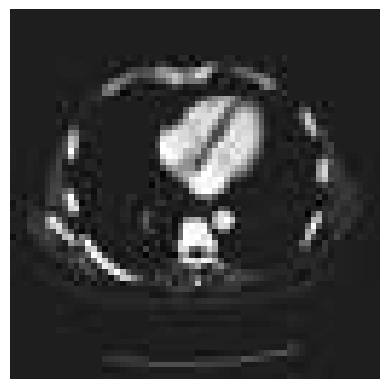

In [3]:
#Cell 2
# Clean up old files
!rm -rf images MedNIST.zip MedNIST.tar.gz MedNIST

# Download from Project MONAI (Reliable source)
!wget -O MedNIST.tar.gz "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"

# Extract the tar file
!tar -xf MedNIST.tar.gz

# Rename the extracted 'MedNIST' folder to 'images' to match the notebook's expectation
!mv MedNIST images

# Verify the contents
!ls -d images/*
!ls -l images/AbdomenCT | wc -l
!ls images/AbdomenCT -1tr | sed -n '2p'

from pathlib import Path

folder = Path("images/AbdomenCT")
files = sorted(
    (f for f in folder.iterdir() if f.is_file()),
    key=lambda f: (f.stat().st_mtime, f.name)   # time, then name
)

img_path = files[1]
print(img_path.name)

from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)

plt.imshow(img, cmap='gray')
plt.axis('off')


In [4]:
import os

#Cell 3
classes_dir = "./images"
flist = os.listdir(classes_dir)
print (flist)

['BreastMRI', 'ChestCT', 'README.md', 'Hand', 'AbdomenCT', 'HeadCT', 'CXR']


### We have already gone through and converted the DICOM images to JPEG (grayscale) images, and also sized so they are all 64x64 (if we kept CXRs as some size other than 64x64, it would cause the CNN to fail--all image MUST be the same size. The next article will explain more about this.



## View data

In [5]:
#Cell 4
from fastai.vision.all import *

np.random.seed(42)
# Update for fastai v2: ImageDataBunch -> ImageDataLoaders
# ds_tfms -> batch_tfms, get_transforms -> aug_transforms
data = ImageDataLoaders.from_folder(classes_dir, valid_pct=0.2,
        item_tfms=Resize(64),
        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
        num_workers=4)

# data.classes is now data.vocab in v2
print(data.vocab)
data.vocab, data.c, len(data.train_ds), len(data.valid_ds)

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


(['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT'],
 6,
 47164,
 11790)

Good! Let's take a look at some of our pictures then.

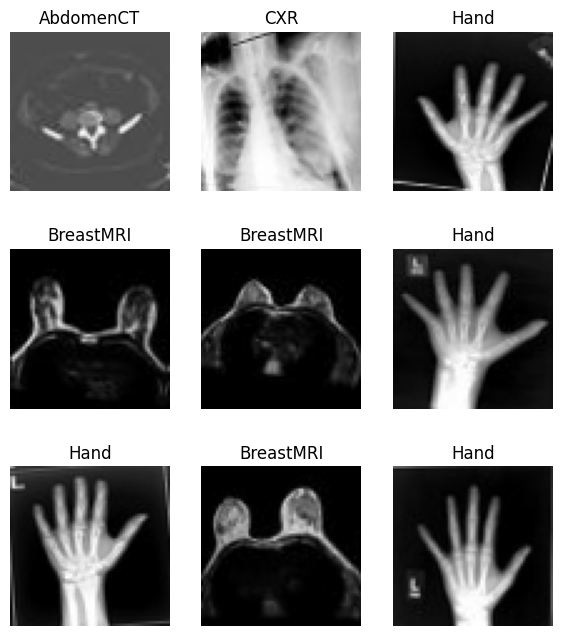

In [6]:
#Cell 5
# v2 uses max_n instead of rows
data.show_batch(max_n=9, figsize=(7,8))

# Helper functions for v1 (commented out as they are incompatible with v2)
# In v2, show_batch() automatically shows augmented versions from the training set.

#def get_img(img_url): return open_image(img_url)

#def plots_of_one_image(img_url, tfms, rows=1, cols=3, width=15, height=5, **kwargs):
#    img = get_img(img_url)
#    [img.apply_tfms(tfms, **kwargs).show(ax=ax)
#         for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]
#
#tfms = get_transforms(flip_vert=False, max_rotate=20.0, max_zoom=1.2)

## Train model

In [7]:
#Cell 6
# cnn_learner is deprecated in fastai v2, replaced by vision_learner
learn = vision_learner(data, models.resnet34, metrics=error_rate)
#learn = vision_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 281MB/s]


In [8]:
#Cell 7
learn.fit_one_cycle(5)
learn.save("MedNIST-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,0.024699,0.002388,0.000594,00:19
1,0.008947,0.001362,0.000509,00:18
2,0.002285,0.004400,0.001442,00:18
3,0.001000,0.000217,0.000000,00:18
4,0.001293,0.002499,0.001018,00:18


Path('images/models/MedNIST-34-1.pth')

#Evaluation
* During the training process, the data is split into 3 parts: training, testing and validation. The training data is used to adjust the weights. The GPU does not have enough RAM to store the entire training set of images, so it is split into 'batches'. When all of the images have been used once for training, then an 'epoch' has passed. Once trained for that epoch, it evaluates how well it has learned using the 'test' data set. The performance on the training set is the train_loss and the performance on the validation set is the valid_loss, and the error_rate is also the percentage of cases wrong in the validation set.
* It is common practice that after 'acceptable' performance is achieved on the vclidation set, that the system is tested on the 'test' data, and that is what is considered the 'real' performance.
* Note that some use 'test' for what is called validation here, and vice versa.

* But sometimes the overall error rate doesn't really tell the story. We might care more about false positives than false negatives, and vica versa. Looking at early results can provide valuable insight into the training process, and how to improve results.

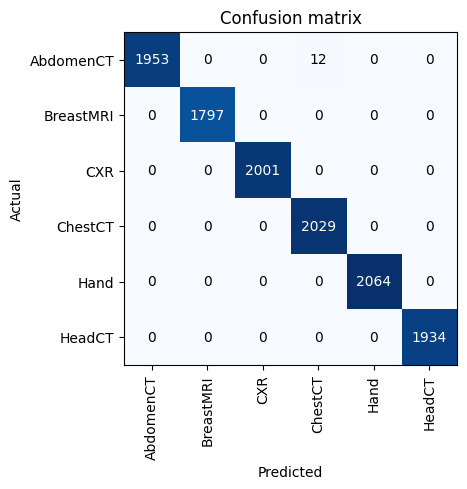

In [9]:
#Cell 8
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Looking closer
* The confusion matrix shows that there is more confusion between chests and abdomens than with heads. Does that surprise you?
* Lets look a little closer at those. FastAI has a nice function that can show you the cases the it did the worst on. Think about that--there are 'errors' but what are the worst errors?
* Well, the class assigned to an image is the class that gets the highest score. So the 'worst' would be those where the score for the correct class was lowest. The function 'plot_top_losses' will show the predicted class, the real class, and the score, as well as the image for the N
(in our case, 9) worst scored cases.
* The second line of code in the cell shows another nice feature of FastAI: to get documentation on any function, just type 'doc(function)' and it will print the documentation for that function. AND it also has a link you can click to then see teh actual source code that implements that function.

Interpretation.plot_top_losses(k: 'int | MutableSequence', largest: 'bool' = True, **kwargs)
Show `k` largest(/smallest) preds and losses. Implementation based on type dispatch

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


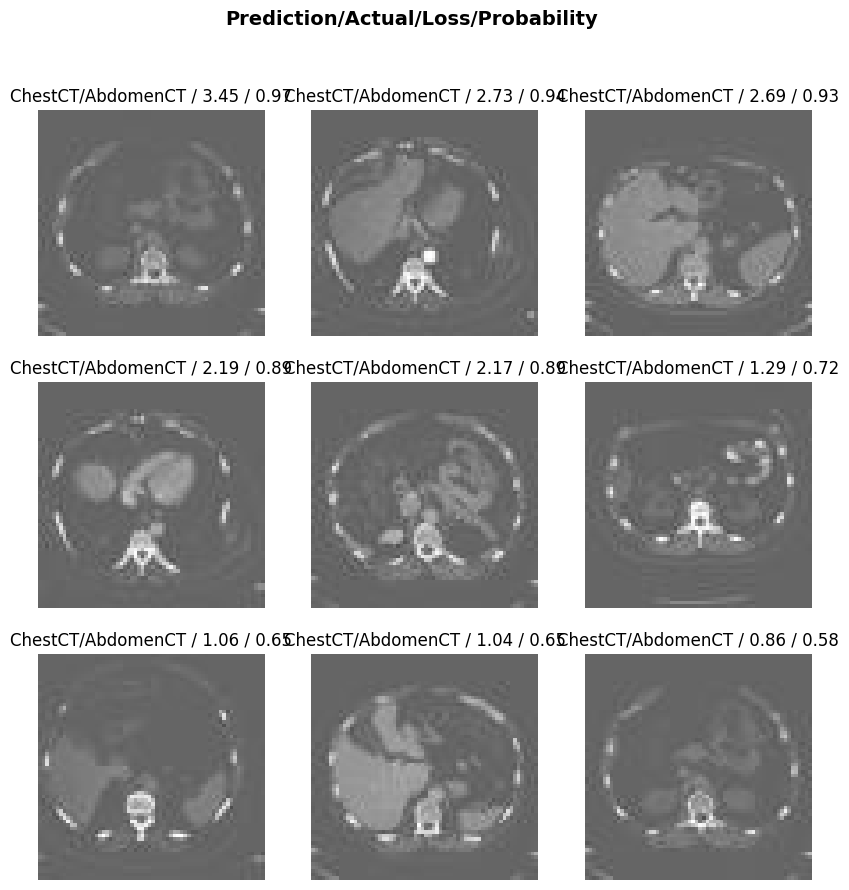

In [11]:
#Cell 9
interp.plot_top_losses(9, figsize=(10,10))
doc(interp.plot_top_losses)

# What do we see?
* Most of the errant classes are slices that contain BOTH lung and abdomen.
* This is an important point: Data preparation and curation is critical to getting good results
* We can argue about how to handle these cases. The correct answer probably depends on your use case. The point is that without seeing these error cases, fyou might never know what was going wrong...


SuggestedLRs()

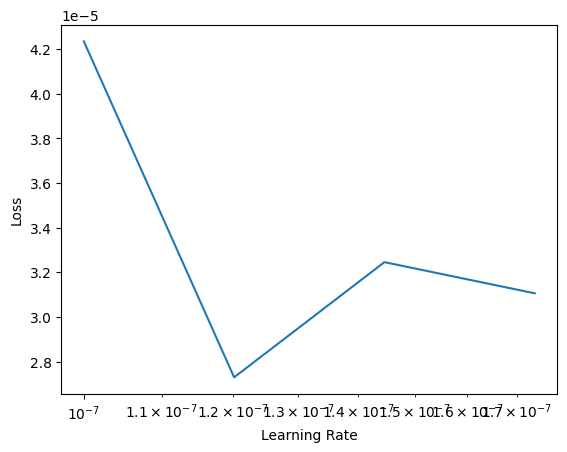

In [12]:
#Cell 10
learn.unfreeze()
# Automatic suggestion failed, so we run without it to just generate the plot
learn.lr_find(suggest_funcs=())

# Extra credit:
* We 'cheated' by starting with a network that was already trained on more than 1,000,000 images. That means the system really only had to learn the specific features of these body parts, but the lower level features like edges and lines were already 'known' to be important to the network.
* On the other hand, the 'pretrained' network was trained on photographic images, which are color, not gray scale, and had a matrix size other than 64x64.
* While we could start from scratch, a better option might be to use the pre-trained values, but allow any of the weights and kernels in the network to be changed, and that is what 'unfreeze' does.

In [13]:
#Cell 11
# Fine-tune the model using learning rates derived from the plot
# We use a slice to apply lower learning rates to early layers and higher to later layers
learn.fit_one_cycle(5, lr_max=slice(3e-6,3e-5))
learn.save("Unfreeze-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,0.001725,0.002045,0.000763,00:20
1,0.000933,0.002510,0.000933,00:21
2,0.000165,0.001441,0.000339,00:20
3,0.000346,0.001285,0.000424,00:21
4,0.000352,0.000167,0.000000,00:21


Path('images/models/Unfreeze-34-1.pth')

# Task
Train a ResNet34 model to classify radiological images using the MedNIST dataset downloaded from "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz". Execute the training loop, evaluate the model's performance by plotting a confusion matrix, and analyze the prediction errors by plotting the top losses.

## Train the model

### Subtask:
Prepare the environment and data, initialize the ResNet34 model, and execute the training loop for 3 epochs.


In [15]:
# Export the model for inference (creates 'export.pkl')
learn.export()

# Check the locations of the saved files
path = Path('images')
print("Saved model weights:", (path/'models').ls())
print("Exported inference model check:", (path/'export.pkl').exists())

Saved model weights: [Path('images/models/MedNIST-34-1.pth'), Path('images/models/Unfreeze-34-1.pth')]
Exported inference model check: True


**Reasoning**:
Generate the code to create the ImageDataLoaders, initialize the ResNet34 model, and execute the training loop for 3 epochs as specified in the subtask instructions.



In [16]:
# Create ImageDataLoaders from the dataset folder
path = Path('images')
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, item_tfms=Resize(64),
                                    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                    num_workers=4)

# Initialize the vision_learner with ResNet34 architecture
learn = vision_learner(data, models.resnet34, metrics=error_rate)

# Execute the training loop for 3 epochs
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.023416,0.005384,0.002205,00:17
1,0.004657,0.001245,0.000424,00:18
2,0.001250,0.003279,0.001018,00:17


Prediction: Hand
Confidence: 1.0000


<Axes: >

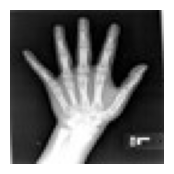

In [18]:
from fastai.vision.all import *

# 1. Load the exported learner
# This recreates the model and all necessary data transforms
learn_inf = load_learner('images/export.pkl')

# 2. Get a sample image to test
# We'll pick the first image from the 'Hand' folder as an example
test_image_path = get_image_files('images/Hand')[0]

# 3. Perform prediction
# pred: the predicted class label (string)
# pred_idx: the index of the predicted class
# probs: the list of probabilities for all classes
pred, pred_idx, probs = learn_inf.predict(test_image_path)

# 4. Display the result
print(f"Prediction: {pred}")
print(f"Confidence: {probs[pred_idx]:.4f}")

# Show the image for confirmation
img = PILImage.create(test_image_path)
img.show()

## Evaluate performance

### Subtask:
Generate a classification interpretation and plot the confusion matrix.


**Reasoning**:
Create a ClassificationInterpretation object from the learner to analyze the model's performance and plot the confusion matrix to visualize the prediction accuracy across classes.



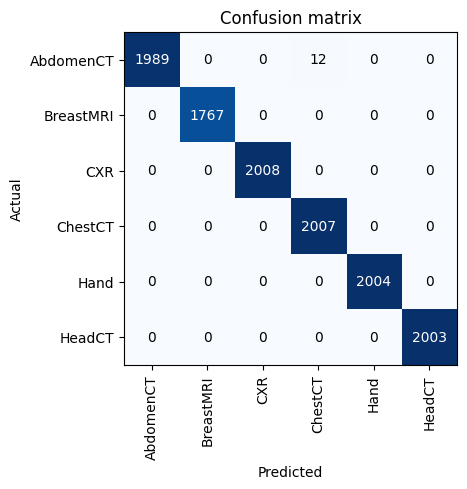

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Analyze errors

### Subtask:
Plot the top losses to visualize the worst prediction errors.


# New Section

# New Section

# New Section

## Summary:

### Data Analysis Key Findings
*   **Model Architecture and Setup**: A ResNet34 model was successfully initialized using `vision_learner` with the `error_rate` metric. The data was prepared using `ImageDataLoaders` with images resized to 64x64, augmented, and normalized using ImageNet statistics.
*   **Training Execution**: The model underwent training for 3 epochs using the `fit_one_cycle` method, completing the process without immediate errors.
*   **Performance Evaluation**: A `ClassificationInterpretation` object was generated from the learner, and a confusion matrix was plotted to visually assess the model's classification performance on the validation set.

### Insights or Next Steps
*   **Error Analysis**: To gain a deeper understanding of misclassifications, the next logical step (as indicated in the context) is to plot the top losses. This will help identify specific samples where the model is most confident but wrong.
*   **Metric Review**: While the confusion matrix provides a visual distribution of errors, reviewing specific quantitative metrics (like precision, recall, or specific error rates per class) would provide concrete benchmarks for model improvement.


# Task
Analyze prediction errors by refreshing the classification interpretation and plotting the top losses to visualize where the model is still making mistakes.

## Analyze prediction errors

### Subtask:
Refresh the classification interpretation and plot the top losses to visualize where the model is still making mistakes.


## Summary:

### Q&A
_No specific questions were posed in the analysis task._

### Data Analysis Key Findings
- The `ClassificationInterpretation` object was successfully refreshed to evaluate the model's current prediction performance.
- The top losses were plotted to visualize specific data points where the model made the most significant errors (high confidence in the wrong answer or low confidence in the right answer).

### Insights or Next Steps
- **Visual Inspection:** Analyzing these top loss images is critical to determine if the errors are due to model limitations (confusion between similar classes) or dataset issues (incorrect labels, poor image quality).
- **Refinement:** If labeling errors are found, the next step should involve cleaning the dataset. If the model is confused by specific features, consider adjusting data augmentation or model architecture.
